In [1]:
%pip install googletrans==3.1.0a0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=9458ba0f8d217f6e95636cad9184751477db481feabc967712b06b4f913614b1
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Successfully uninstalled h11-0.14.0
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: httpcore
    Found existing installation: httpcore 1.0.6
    Uninstalling httpcore-1.0.6:
      Successfully uninstalled httpcore-1.0.6
  Attempting uninstall: httpx
    Found existing installation: httpx 0.27.2
    Uninstalling httpx-0.27.2:
      Successfully uninstalled h

# Transformer based relationship extractor

### Dependencias

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from googletrans import Translator

2024-11-18 04:59:06.535808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 04:59:06.703745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 04:59:06.811446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 04:59:07.088252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Preparación, preprocesamiento y “Feature Engineering”

In [5]:
# Cargar los archivos con el separador adecuado (tabulación)
entities_df = pd.read_csv('entities_train.csv', sep='\t')
abstracts_df = pd.read_csv('abstracts_train.csv', sep='\t')
relations_df = pd.read_csv('relations_train.csv', sep='\t')

# Asegurarse de que todos los identificadores de 'abstract_id' sean strings
entities_df['abstract_id'] = entities_df['abstract_id'].astype(str)
abstracts_df['abstract_id'] = abstracts_df['abstract_id'].astype(str)
relations_df['abstract_id'] = relations_df['abstract_id'].astype(str)

In [3]:
relations_df

,id,abstract_id,type,entity_1_id,entity_2_id,novel
0,0,1353340,Association,410,D007966,No
1,1,1353340,Positive_Correlation,rs74315458,D007966,Novel
2,2,1671881,Positive_Correlation,D010661,rs62514952,Novel
3,3,1671881,Positive_Correlation,D010661,rs62514953,Novel
4,4,1671881,Association,5053,D010661,No
...,...,...,...,...,...,...
4275,4275,30836660,Negative_Correlation,C009172,1278,Novel
4276,4276,30836660,Negative_Correlation,C009172,1277,Novel
4277,4277,30836660,Negative_Correlation,C009172,12825,Novel
4278,4278,30836660,Negative_Correlation,C009172,1281,Novel


In [4]:
abstracts_df

,abstract_id,title,abstract
0,1353340,Late-onset metachromatic leukodystrophy: molec...,We report on a new allele at the arylsulfatase...
1,1671881,Two distinct mutations at a single BamHI site ...,Classical phenylketonuria is an autosomal rece...
2,1848636,Debrisoquine phenotype and the pharmacokinetic...,The metabolism of the cardioselective beta-blo...
3,2422478,Midline B3 serotonin nerves in rat medulla are...,Previous experiments in this laboratory have s...
4,2491010,Molecular and phenotypic analysis of patients ...,Eighty unrelated individuals with Duchenne mus...
...,...,...,...
395,28851297,An Ag-globin G->A gene polymorphism associated...,BACKGROUND: Increase of the expression of g-gl...
396,28883039,Disease-associated mutations in human BICD2 hy...,Bicaudal D2 (BICD2) joins dynein with dynactin...
397,29049388,An inducible mouse model of podocin-mutation-r...,"Mutations in the NPHS2 gene, encoding podocin,..."
398,29183288,Arginase 1 deletion in myeloid cells affects t...,BACKGROUND: (Over-)expression of arginase may ...


In [6]:
entities_df

,id,abstract_id,offset_start,offset_finish,type,mention,entity_ids
0,0,1353340,11,39,DiseaseOrPhenotypicFeature,metachromatic leukodystrophy,D007966
1,1,1353340,111,126,GeneOrGeneProduct,arylsulfatase A,410
2,2,1353340,128,132,GeneOrGeneProduct,ARSA,410
3,3,1353340,159,187,DiseaseOrPhenotypicFeature,metachromatic leukodystrophy,D007966
4,4,1353340,189,192,DiseaseOrPhenotypicFeature,MLD,D007966
...,...,...,...,...,...,...,...
13631,13631,30836660,2237,2241,GeneOrGeneProduct,TLR4,"21898,7099"
13632,13632,30836660,2242,2251,GeneOrGeneProduct,NF-kappaB,"18033,4790"
13633,13633,30836660,2256,2260,GeneOrGeneProduct,MAPK,"26413,5594"
13634,13634,30836660,2344,2347,ChemicalEntity,Sal,C009172


In [7]:
from googletrans import Translator
import time
# Initialize the translator
translator = Translator()

# Function for back translation
def back_translation(text, src_lang='en', intermediate_lang='fr'):
    """Translate the text to an intermediate language and back to the original language."""
    try:
        translated_text = translator.translate(text, src=src_lang, dest=intermediate_lang).text
        back_translated_text = translator.translate(translated_text, src=intermediate_lang, dest=src_lang).text
        print(back_translated_text)
        return back_translated_text
    except Exception as e:
        print(f"Translation error: {e}")
        return text  # Fallback to the original text if an error occurs

# Sample DataFrame with your data
df = pd.DataFrame(abstracts_df)

# Apply back translation to create augmented data
df['abstract'] = df['abstract'].apply(lambda x: back_translation(x) if pd.notnull(x) else x)

# Create a new DataFrame for back-translated data
back_translated_df = pd.DataFrame(df)
back_translated_df

We report a novel allele at the arylsulfatase A (ARSA) locus causing late-onset metachromatic leukodystrophy (MLD). In this allele, arginine84, a highly conserved residue in the arylsulfatase gene family, is replaced by glutamine. Unlike alleles that cause early MLD, substitution of arginine84 for glutamine is associated with some residual ARSA activity. A comparison of genotypes, ARSA activities, and clinical data on 4 individuals carrying the allele from 81 MLD patients examined further validates the concept that different degrees of residual ARSA activity underlie the Phenotypic variation in MLD.
Classic phenylketonuria is an autosomal recessive disorder caused by hepatic phenylalanine hydroxylase (PAH) deficiency. The abolition of an invariant BamHI site located in the coding sequence of the PAH gene (exon 7) led to the recognition of two new point mutations at codons 272 and 273 (272gly----stop and 273ser--- -phe, respectively). Both mutations were detected in the north-east of Fr

,abstract_id,title,abstract
0,1353340,Late-onset metachromatic leukodystrophy: molec...,We report a novel allele at the arylsulfatase ...
1,1671881,Two distinct mutations at a single BamHI site ...,Classic phenylketonuria is an autosomal recess...
2,1848636,Debrisoquine phenotype and the pharmacokinetic...,The metabolism of the cardioselective beta-blo...
3,2422478,Midline B3 serotonin nerves in rat medulla are...,Previous experiments in this laboratory have s...
4,2491010,Molecular and phenotypic analysis of patients ...,Eighty unrelated individuals with Duchenne mus...
...,...,...,...
395,28851297,An Ag-globin G->A gene polymorphism associated...,BACKGROUND: Increased g-globin gene expression...
396,28883039,Disease-associated mutations in human BICD2 hy...,Bicaudal D2 (BICD2) joins dynein and dynactin ...
397,29049388,An inducible mouse model of podocin-mutation-r...,"Mutations in the NPHS2 gene, encoding podocin,..."
398,29183288,Arginase 1 deletion in myeloid cells affects t...,BACKGROUND:(Over)expression of arginase may li...


In [8]:
concatenation = [abstracts_df, back_translated_df]
abstract_df = pd.concat(concatenation)

In [9]:
abstract_df

,abstract_id,title,abstract
0,1353340,Late-onset metachromatic leukodystrophy: molec...,We report on a new allele at the arylsulfatase...
1,1671881,Two distinct mutations at a single BamHI site ...,Classical phenylketonuria is an autosomal rece...
2,1848636,Debrisoquine phenotype and the pharmacokinetic...,The metabolism of the cardioselective beta-blo...
3,2422478,Midline B3 serotonin nerves in rat medulla are...,Previous experiments in this laboratory have s...
4,2491010,Molecular and phenotypic analysis of patients ...,Eighty unrelated individuals with Duchenne mus...
...,...,...,...
395,28851297,An Ag-globin G->A gene polymorphism associated...,BACKGROUND: Increased g-globin gene expression...
396,28883039,Disease-associated mutations in human BICD2 hy...,Bicaudal D2 (BICD2) joins dynein and dynactin ...
397,29049388,An inducible mouse model of podocin-mutation-r...,"Mutations in the NPHS2 gene, encoding podocin,..."
398,29183288,Arginase 1 deletion in myeloid cells affects t...,BACKGROUND:(Over)expression of arginase may li...


In [10]:
# Unir los resúmenes con las relaciones usando 'abstract_id'
merged_df = pd.merge(relations_df, abstract_df[['abstract_id', 'abstract', 'title']], on='abstract_id', how='inner')

merged_df.head()

# Guardar el DataFrame en un archivo CSV para futuros usos
# merged_df.to_csv('merged.csv', index=False)

,id,abstract_id,type,entity_1_id,entity_2_id,novel,abstract,title
0,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...
1,0,1353340,Association,410,D007966,No,We report a novel allele at the arylsulfatase ...,Late-onset metachromatic leukodystrophy: molec...
2,1,1353340,Positive_Correlation,rs74315458,D007966,Novel,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...
3,1,1353340,Positive_Correlation,rs74315458,D007966,Novel,We report a novel allele at the arylsulfatase ...,Late-onset metachromatic leukodystrophy: molec...
4,2,1671881,Positive_Correlation,D010661,rs62514952,Novel,Classical phenylketonuria is an autosomal rece...,Two distinct mutations at a single BamHI site ...


In [11]:
# Unir la información de las entidades, primero para 'entity_1' y luego para 'entity_2'
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_1_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')



# Renombrar las columnas para la entidad 1
merged_df.rename(columns={'mention': 'entity_1_mention', 'type_y': 'entity_1_type'}, inplace=True)

merged_df.head()

,id,abstract_id,type_x,entity_1_id,entity_2_id,novel,abstract,title,entity_ids,entity_1_mention,entity_1_type
0,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct
1,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,ARSA,GeneOrGeneProduct
2,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase,GeneOrGeneProduct
3,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,ARSA,GeneOrGeneProduct
4,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,ARSA,GeneOrGeneProduct


In [12]:
merged_df.columns

Index(['id', 'abstract_id', 'type_x', 'entity_1_id', 'entity_2_id', 'novel',
       'abstract', 'title', 'entity_ids', 'entity_1_mention', 'entity_1_type'],
      dtype='object')

In [13]:
# Unir nuevamente con las entidades para obtener la entidad 2
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_2_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')

# Renombrar las columnas para la entidad 2
merged_df.rename(columns={'mention': 'entity_2_mention', 'type': 'entity_2_type'}, inplace=True)

# Verificar el DataFrame de entrenamiento
merged_df.head()

,id,abstract_id,type_x,entity_1_id,entity_2_id,novel,abstract,title,entity_ids_x,entity_1_mention,entity_1_type,entity_ids_y,entity_2_mention,entity_2_type
0,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct,D007966,metachromatic leukodystrophy,DiseaseOrPhenotypicFeature
1,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct,D007966,metachromatic leukodystrophy,DiseaseOrPhenotypicFeature
2,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct,D007966,MLD,DiseaseOrPhenotypicFeature
3,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct,D007966,MLD,DiseaseOrPhenotypicFeature
4,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct,D007966,MLD,DiseaseOrPhenotypicFeature


In [14]:
print("Columnas disponibles después de la fusión:", merged_df.columns)
merged_df.info()
merged_df.to_csv('merged.csv', index=False)

Columnas disponibles después de la fusión: Index(['id', 'abstract_id', 'type_x', 'entity_1_id', 'entity_2_id', 'novel',
       'abstract', 'title', 'entity_ids_x', 'entity_1_mention',
       'entity_1_type', 'entity_ids_y', 'entity_2_mention', 'entity_2_type'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147820 entries, 0 to 147819
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                147820 non-null  int64 
 1   abstract_id       147820 non-null  object
 2   type_x            147820 non-null  object
 3   entity_1_id       147820 non-null  object
 4   entity_2_id       147820 non-null  object
 5   novel             147820 non-null  object
 6   abstract          147820 non-null  object
 7   title             147820 non-null  object
 8   entity_ids_x      147820 non-null  object
 9   entity_1_mention  147820 non-null  object
 10  entity_1_type     147820 non-null  o

In [15]:
# Drop any potential duplicates
merged_df = merged_df.drop_duplicates()

# Retain only necessary columns for relationship extraction
merged_df = merged_df[['abstract_id', 'abstract', 'type_x', 'entity_1_mention', 'entity_2_mention', 'entity_1_type', 'entity_2_type']]

merged_df.head()


,abstract_id,abstract,type_x,entity_1_mention,entity_2_mention,entity_1_type,entity_2_type
0,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase A,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
2,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase A,MLD,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
6,1353340,We report on a new allele at the arylsulfatase...,Association,ARSA,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
8,1353340,We report on a new allele at the arylsulfatase...,Association,ARSA,MLD,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
12,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature


In [16]:
merged_df

,abstract_id,abstract,type_x,entity_1_mention,entity_2_mention,entity_1_type,entity_2_type
0,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase A,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
2,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase A,MLD,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
6,1353340,We report on a new allele at the arylsulfatase...,Association,ARSA,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
8,1353340,We report on a new allele at the arylsulfatase...,Association,ARSA,MLD,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
12,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
...,...,...,...,...,...,...,...
147711,30836660,Salidroside (Sal) is an active ingredient isol...,Negative_Correlation,Sal,renal fibrosis,ChemicalEntity,DiseaseOrPhenotypicFeature
147712,30836660,Salidroside (Sal) is an active ingredient isol...,Negative_Correlation,Sal,renal interstitial fibrosis,ChemicalEntity,DiseaseOrPhenotypicFeature
147713,30836660,Salidroside (Sal) is an active ingredient isol...,Negative_Correlation,Sal,RIF,ChemicalEntity,DiseaseOrPhenotypicFeature
147715,30836660,Salidroside (Sal) is an active ingredient isol...,Negative_Correlation,Sal,renal damage,ChemicalEntity,DiseaseOrPhenotypicFeature


In [17]:
def insert_entity_tokens(row):
    abstract = row['abstract']
    e1_mention = row['entity_1_mention']
    e2_mention = row['entity_2_mention']
    
    # Insert unique markers for each entity
    abstract = abstract.replace(e1_mention, f"[ENTITY_1]{e1_mention}[/ENTITY_1]")
    abstract = abstract.replace(e2_mention, f"[ENTITY_2]{e2_mention}[/ENTITY_2]")
    return abstract

# Apply tokenization to abstracts
merged_df['processed_abstract'] = merged_df.apply(insert_entity_tokens, axis=1)

# Verify output
print(merged_df[['processed_abstract']].head())


                                   processed_abstract
0   We report on a new allele at the [ENTITY_1]ary...
2   We report on a new allele at the [ENTITY_1]ary...
6   We report on a new allele at the arylsulfatase...
8   We report on a new allele at the arylsulfatase...
12  We report on a new allele at the [ENTITY_1]ary...


In [18]:
merged_df.head()

,abstract_id,abstract,type_x,entity_1_mention,entity_2_mention,entity_1_type,entity_2_type,processed_abstract
0,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase A,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,We report on a new allele at the [ENTITY_1]ary...
2,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase A,MLD,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,We report on a new allele at the [ENTITY_1]ary...
6,1353340,We report on a new allele at the arylsulfatase...,Association,ARSA,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,We report on a new allele at the arylsulfatase...
8,1353340,We report on a new allele at the arylsulfatase...,Association,ARSA,MLD,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,We report on a new allele at the arylsulfatase...
12,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,We report on a new allele at the [ENTITY_1]ary...


In [19]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [21]:
# Concatenate the columns to create a combined feature for relationship
merged_df['combined_type'] = merged_df['entity_1_type'] + '~' + merged_df['type_x'] + '~' + merged_df['entity_2_type']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the combined feature
merged_df['relationship_label'] = label_encoder.fit_transform(merged_df['combined_type'])

# Save processed data to CSV
processed_data = merged_df[['processed_abstract', 'entity_1_type', 'entity_2_type', 'relationship_label']]
processed_data.head()

,processed_abstract,entity_1_type,entity_2_type,relationship_label
0,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,27
2,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,27
6,We report on a new allele at the arylsulfatase...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,27
8,We report on a new allele at the arylsulfatase...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,27
12,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,27


In [22]:
import joblib

# Save the fitted LabelEncoder to a file
joblib.dump(label_encoder, 'label_encoder.pkl')
print("LabelEncoder saved to label_encoder.pkl")


LabelEncoder saved to label_encoder.pkl


In [23]:
processed_data.to_csv('processed_data.csv', index=False)

### Definición y entrenamiento de modelo

In [13]:
processed_data = pd.read_csv('processed_data.csv')
processed_data.head() # Reimportamos la información para no redundar con el preprocesamiento

,processed_abstract,entity_1_type,entity_2_type,relationship_label
0,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
1,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
2,We report on a new allele at the arylsulfatase...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
3,We report on a new allele at the arylsulfatase...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
4,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0


## Data Augmentation

In [13]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

def tokenize_data(examples):
    return tokenizer(examples['processed_abstract'], padding="max_length", truncation=True)

# Apply tokenization to the whole dataset
# tokenized_data = processed_data.apply(lambda row: tokenize_data(row), axis=1)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
X = processed_data['processed_abstract']
y = processed_data['relationship_label']

# Step 1: Split into training (70%) and temporary (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Step 2: Split the temporary set (30%) into validation (66% of 30%) and test (33% of 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42
)

# Check the distribution
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 7835
Validation set size: 2238
Test set size: 1120


In [15]:
# Define max sequence length for BERT input
maxlen = 200

# Tokenize training data
train_encodings = tokenizer(
    X_train.tolist(), # Convert to list for batch tokenization
    truncation=True,
    padding="max_length",
    max_length=maxlen
)

# Tokenize testing data
test_encodings = tokenizer(
    X_val.tolist(),
    truncation=True,
    padding="max_length",
    max_length=maxlen
)

In [16]:
class RelationshipDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert to torch Dataset objects
train_dataset = RelationshipDataset(train_encodings, y_train.tolist())
test_dataset = RelationshipDataset(test_encodings, y_test.tolist())


In [17]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [18]:
torch.cuda.is_available()

True

In [19]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example of creating a tensor on the GPU
tensor = torch.tensor([1.0, 2.0, 3.0], device=device)

# Move your model to the GPU
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
# Freeze first model layers
for param in model.bert.encoder.layer[:6].parameters():
    param.requires_grad = False

# Set up training arguments
# Modificar los argumentos de entrenamiento para incluir acumulación de gradientes
training_args = TrainingArguments(
    output_dir='./results',               # Directorio de salida para checkpoints
    eval_strategy='epoch',          # Evaluar al final de cada epoch
    per_device_train_batch_size=8,        # Tamaño de batch para entrenamiento
    per_device_eval_batch_size=8,         # Tamaño de batch para evaluación
    gradient_accumulation_steps=4,        # Acumulación de gradientes cada 4 pasos
    num_train_epochs=10,                  # Total de épocas (con early stopping)
    learning_rate=2e-5,                   # Tasa de aprendizaje
    logging_dir='./logs',                 # Directorio de logs
    save_strategy='epoch',                # Guardar al final de cada epoch
    load_best_model_at_end=True,          # Cargar el mejor modelo al final del entrenamiento
    metric_for_best_model='eval_loss',    # Métrica de referencia para el mejor modelo
    greater_is_better=False,              # Indicar que menor pérdida es mejor
    save_total_limit=2                    # Limitar el número de checkpoints guardados
)

# Initialize Trainer with model, arguments, dataset, and metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [21]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.388587,0.424107,0.399285,0.394554,0.424107
2,No log,1.681407,0.424107,0.419042,0.414117,0.424107
3,0.893100,1.772071,0.433036,0.422772,0.413817,0.433036
4,0.893100,1.958666,0.433036,0.422575,0.416507,0.433036


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

TrainOutput(global_step=980, training_loss=0.7504183399433992, metrics={'train_runtime': 1070.9154, 'train_samples_per_second': 73.162, 'train_steps_per_second': 2.288, 'total_flos': 3221228396352000.0, 'train_loss': 0.7504183399433992, 'epoch': 4.0})

In [22]:
# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 1.3885866403579712, 'eval_accuracy': 0.42410714285714285, 'eval_f1': 0.3992849313332199, 'eval_precision': 0.3945537857100319, 'eval_recall': 0.42410714285714285, 'eval_runtime': 11.0497, 'eval_samples_per_second': 101.36, 'eval_steps_per_second': 12.67, 'epoch': 4.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Visualización de resultados

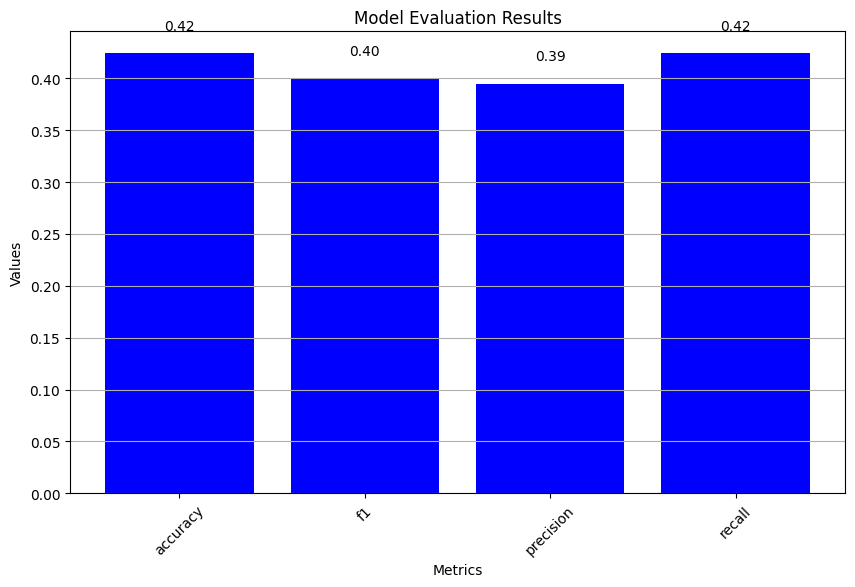

In [23]:
# Extract metrics
metrics = ['accuracy','f1','precision','recall']
values = [eval_results[f"eval_{metric}"] for metric in metrics]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color='blue')
plt.title('Model Evaluation Results')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add value labels above each bar
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate for the label
        bar.get_height() + 0.02,            # Y-coordinate, a bit above the bar
        f"{value:.2f}",                     # Value label, rounded to 2 decimals
        ha='center', va='bottom'            # Center alignment
    )

# Show plot
plt.show()

In [24]:
model.save_pretrained('./relationship_model')
tokenizer.save_pretrained('./relationship_model')
pd.to_pickle(label_encoder, './relationship_model/label_encoder.pkl')

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

In [26]:
from datasets import Dataset

# Convert the Series to a Dataset
train_dataset = Dataset.from_pandas(X_train.to_frame(name="text"))
val_dataset = Dataset.from_pandas(X_val.to_frame(name="text"))
test_dataset = Dataset.from_pandas(X_test.to_frame(name="text"))

In [27]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("relationship_model")  # Replace with your model's name

def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/7835 [00:00<?, ? examples/s]

Map:   0%|          | 0/2238 [00:00<?, ? examples/s]

Map:   0%|          | 0/1120 [00:00<?, ? examples/s]

In [28]:
# Get predictions on the training set
train_preds = trainer.predict(tokenized_train_dataset)

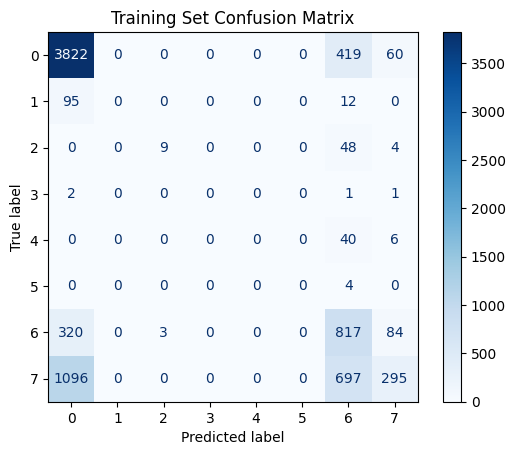

In [29]:
y_train_pred = np.argmax(train_preds.predictions, axis=1)

# Plot confusion matrix for the training set
plot_confusion_matrix(y_train, y_train_pred, title="Training Set Confusion Matrix")

In [30]:
# Get predictions on the validation set
val_preds = trainer.predict(tokenized_val_dataset)

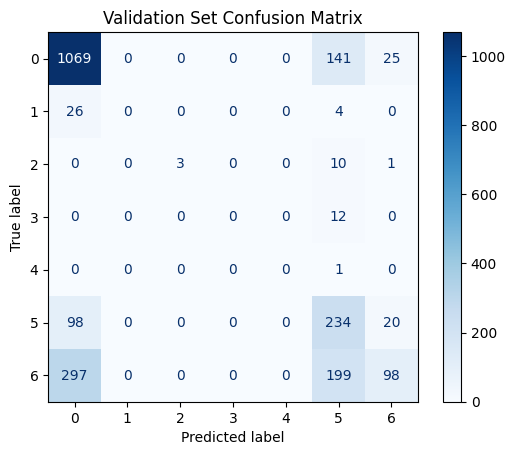

In [32]:
y_val_pred = np.argmax(val_preds.predictions, axis=1)

# Plot confusion matrix for the validation set
plot_confusion_matrix(y_val, y_val_pred, title="Validation Set Confusion Matrix")

In [33]:
# Get predictions on the test set
test_preds = trainer.predict(tokenized_test_dataset)

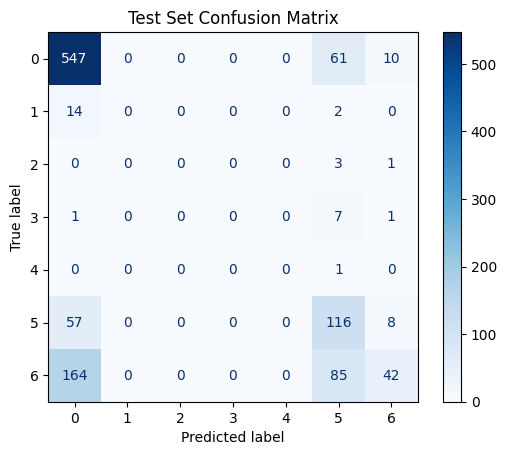

In [34]:
y_test_pred = np.argmax(test_preds.predictions, axis=1)

# Plot confusion matrix for the test set
plot_confusion_matrix(y_test, y_test_pred, title="Test Set Confusion Matrix")